LangGraph is just better to represent agent control flow. We use graphs here

| Normal code     | LangGraph        |
| --------------- | ---------------- |
| query           | state            |
| should_retrieve | conditional edge |
| retrieve()      | node             |
| answer()        | node             |
| if/else         | graph routing    |

Use LangGraph if:
- more than 1 if/else decision is needed
- loops are there: fetch ans-> is it good? -> improve
- observability & debugging (in production)
- colab with teams

In [2]:
import faiss
import numpy as np
import os
import time
import random

from sentence_transformers import SentenceTransformer
from openai import OpenAI
from mistralai import Mistral

#boring stuff
import os
from dotenv import load_dotenv

load_dotenv()
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
MISTRAL_API_KEY = os.getenv("MISTRAL_API_KEY")

if not OPENROUTER_API_KEY:
    raise ValueError("OPENROUTER_API_KEY missing in environment")

# 1. Documents

documents = [
    "RAG stands for Retrieval-Augmented Generation.",
    "In RAG, documents are embedded into a vector space.",
    "FAISS is a library for efficient similarity search.",
    "Large Language Models can hallucinate without grounding.",
    "Embeddings capture semantic meaning of text.",
    "Ronaldo has played for Real Madrid, Manchester United, Juventus, Sporting Lisbon, Portugal and Al Nassr."
]

# 2. Chunking

def chunk(text, size=50):
    words = text.split()
    return [" ".join(words[i:i+size]) for i in range(0, len(words), size)]

chunks = []
for d in documents:
    chunks.extend(chunk(d))

# 3. Embeddings

embedder = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedder.encode(chunks).astype("float32")

# ----------------------------
# 4. FAISS index
# ----------------------------
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

# ----------------------------
# 5. Retrieval tool
# ----------------------------
def retrieve(query, k=2):
    q_emb = embedder.encode([query]).astype("float32")
    _, idx = index.search(q_emb, k)
    return [chunks[i] for i in idx[0]]

# ----------------------------
# 6. LLM client 
# ----------------------------
openrouter = OpenAI( #Primary 
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
)

mistral = Mistral( # secondary
    api_key=os.getenv("MISTRAL_API_KEY", "")
)

# ----------------------------
# 7. Chat with fallback
# ----------------------------

def chat_with_fallback(messages, model_primary="stepfun/step-3.5-flash:free"):
    try:
        # PRIMARY: OpenRouter
        response = openrouter.chat.completions.create(
            model=model_primary,
            messages=messages,
        )
        return response.choices[0].message.content

    except Exception as e:
        print("⚠️ OpenRouter failed, falling back to Mistral:", e)

        # Optional small delay so you don't immediately re-hit limits
        time.sleep(1 + random.random())

        # FALLBACK: Mistral
        res = mistral.chat.complete(
            model="mistral-small-latest",
            messages=messages,
            stream=False,
        )
        return res.choices[0].message.content

# 8. Retrieval with scores (for agentic RAG)

def retrieve_with_scores(query, k=2):
    q_emb = embedder.encode([query]).astype("float32")
    distances, indices = index.search(q_emb, k)

    results = []
    for dist, idx in zip(distances[0], indices[0]):
        results.append({
            "text": chunks[idx],
            "distance": float(dist)
        })

    return results

# ---------------------------- 
# 9. Answer step
# ----------------------------
def answer(query, context=None):
    if context:
        prompt = f"""
Answer using ONLY the context below. Answer in less than 50 words.
If the answer is not present, say "I don't know".

Context:
{context}

Question:
{query}
"""
    else:
        prompt = query

    return chat_with_fallback([
        {"role": "user", "content": prompt}
    ])


# pick a threshold
THRESHOLD = 1.2

# cheaper decision maker 

def should_retrieve(query, threshold=1.2):
    results = retrieve_with_scores(query, k=1)
    best_distance = results[0]["distance"]

    print("Best distance:", best_distance)

    return best_distance < threshold


# updated Agent loop
#----------This is the only part the LangGraph replaces------

def agent(query):
    if should_retrieve(query):
        results = retrieve_with_scores(query)
        context = "\n".join(r["text"] for r in results)
        print("Decision: retrieve")
        print("Context:", context)
        return answer(query, context)
    else:
        print("Decision: answer")
        return answer(query)
#-------------------------------------------------------------

/Users/satvikraghav/coding/RAG/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1122.16it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


1. Define the state using TypeDict

we have
- query: which is an str
- context: also str
- answer: also str

In [1]:
from typing import TypedDict, Optional

class AgentState(TypedDict):
    query: str
    context: Optional[str]
    answer: Optional[str]

2. Define "nodes" or the key things to be done
- retrieve 
  - threshold
- answer

In [3]:
def retrieval_node(state: AgentState) -> AgentState:
    results = retrieve_with_scores(state["query"])
    context = "\n".join(r["text"] for r in results)
    return {**state, "context": context}


def answer_node(state: AgentState) -> AgentState:
    response = answer(state["query"], state.get("context"))
    return {**state, "answer": response}


The threshold

In [4]:
def route(state: AgentState) -> str:
    if should_retrieve(state["query"]):
        return "retrieve"
    return "answer"

We make the graph

In [6]:
from langgraph.graph import StateGraph, END, START

graph = StateGraph(AgentState)

graph.add_node("retrieve", retrieval_node)
graph.add_node("answer", answer_node)

graph.add_conditional_edges(
    START,
    route,
    {
        "retrieve": "retrieve",
        "answer": "answer",
    }
)

graph.add_edge("retrieve", "answer")
graph.add_edge("answer", END)

app = graph.compile()


Testing:

In [8]:
result = app.invoke({
    "query": "What clubs did Ronaldo play for?",
    "context": None,
    "answer": None,
})

print(result["answer"])

Best distance: 0.503292977809906
⚠️ OpenRouter failed, falling back to Mistral: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-day. Add 10 credits to unlock 1000 free model requests per day', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '50', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1770422400000'}, 'provider_name': None}}, 'user_id': 'user_33JOveQTDfa8tzJHX8UiRsza1LT'}
⚠️ OpenRouter failed, falling back to Mistral: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-day. Add 10 credits to unlock 1000 free model requests per day', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '50', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1770422400000'}, 'provider_name': None}}, 'user_id': 'user_33JOveQTDfa8tzJHX8UiRsza1LT'}
Ronaldo played for Sporting Lisbon, Manchester United, Real Madrid, Juventus, and Al Nassr.
Ronaldo played for Sporting Lisbon, Manchester United, Real Madrid, Juventus, and A

### More advanced 

Adding 
- Add a confidence_check node 
- Add a refuse_answer node 
- Add a summarise_context node Log distances into state

In [16]:
# Step 1: importing
from typing import TypedDict, List, Optional
from langgraph.graph import StateGraph, END

# Step 2: State definitions

class AgentState(TypedDict):
    query: str
    context: Optional[str]
    answer: Optional[str]
    #----------------------------
    distances: List[float] 
    decision: str
    confidence: Optional[float]


In [17]:
# 3. Nodes

# retrieval decision node 
def decision_node(state: AgentState):
    results = retrieve_with_scores(state["query"], k=1)
    best_distance = results[0]["distance"]

    state["distances"] = [best_distance]

    if best_distance < THRESHOLD:
        state["decision"] = "retrieve"
    else:
        state["decision"] = "answer"

    return state

# retieve node
def retrieve_node(state: AgentState):
    results = retrieve_with_scores(state["query"], k=3)
    state["distances"] = [r["distance"] for r in results]
    state["context"] = "\n".join(r["text"] for r in results)
    return state

In [18]:
# SUMMARIZE context window node (NEW)
def summarise_context_node(state: AgentState):
    prompt = f"""
Summarise the following context in less than 60 words.
Preserve factual details.

Context:
{state["context"]}
"""
    summary = chat_with_fallback([
        {"role": "user", "content": prompt}
    ])

    state["context"] = summary
    return state

In [19]:
# Answer node
def answer_node(state: AgentState):
    if state.get("context"):
        response = answer(state["query"], state["context"])
    else:
        response = answer(state["query"])

    state["answer"] = response
    return state

# CONFIDANCE CHECK NODE (NEW)

def confidence_check_node(state: AgentState):
    prompt = f"""
Give a confidence score between 0 and 1 for the following answer.
Only output the number.

Answer:
{state["answer"]}
"""
    confidence = chat_with_fallback([
        {"role": "user", "content": prompt}
    ])

    try:
        state["confidence"] = float(confidence.strip())
    except:
        state["confidence"] = 0.0

    return state

# REFUSE ANSWER NODE (NEW)
def refuse_answer_node(state: AgentState):
    state["answer"] = "I’m not confident enough to answer this reliably."
    return state

In [20]:
# Graph building
graph = StateGraph(AgentState)

graph.add_node("decide", decision_node)
graph.add_node("retrieve", retrieve_node)
graph.add_node("summarise", summarise_context_node)
graph.add_node("answer", answer_node)
graph.add_node("confidence_check", confidence_check_node)
graph.add_node("refuse", refuse_answer_node)

graph.set_entry_point("decide")

# Conditional routing

graph.add_conditional_edges(
    "decide",
    lambda s: s["decision"],
    {
        "retrieve": "retrieve",
        "answer": "answer"
    }
)

graph.add_edge("retrieve", "summarise")
graph.add_edge("summarise", "answer")
graph.add_edge("answer", "confidence_check")

# Confidence based refusal
def confidence_router(state: AgentState):
    return "refuse" if state["confidence"] < 0.4 else END

graph.add_conditional_edges(
    "confidence_check",
    confidence_router,
    {
        "refuse": "refuse",
        END: END
    }
)

graph.add_edge("refuse", END)

# Compile 
agent_app = graph.compile()

# test run
result = agent_app.invoke({
    "query": "What clubs did Ronaldo play for?",
    "distances": [],
    "context": None,
    "decision": "",
    "answer": None,
    "confidence": None
})

print(result)

{'query': 'What clubs did Ronaldo play for?', 'context': "Ronaldo has played for Real Madrid, Manchester United, Juventus, Sporting Lisbon, Portugal's national team, and Al Nassr. FAISS is a library for efficient similarity search. Large Language Models may generate false information (hallucinate) without proper grounding.", 'answer': 'Real Madrid, Manchester United, Juventus, Sporting Lisbon, and Al Nassr.', 'distances': [0.503292977809906, 1.8585604429244995, 1.951742172241211], 'decision': 'retrieve', 'confidence': 1.0}


## Even more advanced

Adding more advanced stuff

1. Retry loop: 
If confidence is low → retrieve again with higher k

2. 📊 Retrieval diagnostics
   > Track:
     - distances
        - avg distance
        - min distance
     - retrieval count

3. Memory
Very simple episodic memory:
- Store (question, answer, confidence)
- Reuse if a similar question appears again

4. Automated evaluation: (LLM based)
- is the answer supported by context 
- a score

In [21]:
# Update state
class AgentState(TypedDict):
    query: str
    distances: List[float]
    context: Optional[str]
    decision: str
    answer: Optional[str]
    confidence: Optional[float]

    # NEW
    retries: int
    retrieval_stats: dict
    memory_hit: bool
    eval_score: Optional[float]

### Memory store

In [22]:
memory_store = []

1. Lookup memory 

In [23]:
def memory_lookup_node(state: AgentState):
    for item in memory_store:
        if item["query"].lower() == state["query"].lower():
            state["answer"] = item["answer"]
            state["confidence"] = item["confidence"]
            state["memory_hit"] = True
            return state

    state["memory_hit"] = False
    return state


2. Memory write node

In [24]:
def memory_write_node(state: AgentState):
    memory_store.append({
        "query": state["query"],
        "answer": state["answer"],
        "confidence": state["confidence"]
    })
    return state


Retrieval diagnostics

In [25]:
# update retrieval node
def retrieve_node(state: AgentState):
    results = retrieve_with_scores(state["query"], k=3)

    distances = [r["distance"] for r in results]

    state["distances"] = distances
    state["context"] = "\n".join(r["text"] for r in results)

    state["retrieval_stats"] = {
        "min": min(distances),
        "avg": sum(distances) / len(distances),
        "count": len(distances)
    }

    return state

# Retry loop (agentic)

MAX_RETRIES = 2

def retry_router(state: AgentState):
    if state["confidence"] < 0.4 and state["retries"] < MAX_RETRIES:
        return "retry"
    elif state["confidence"] < 0.4:
        return "refuse"
    else:
        return END

# retry node

def retry_node(state: AgentState):
    state["retries"] += 1
    return state

# automated evaluation node (NEW)

def eval_node(state: AgentState):
    if not state.get("context"):
        state["eval_score"] = 1.0
        return state

    prompt = f"""
Is the answer fully supported by the context?
Score between 0 and 1. Only output the number.

Context:
{state["context"]}

Answer:
{state["answer"]}
"""
    score = chat_with_fallback([
        {"role": "user", "content": prompt}
    ])

    try:
        state["eval_score"] = float(score.strip())
    except:
        state["eval_score"] = 0.0

    return state


In [43]:
# update the graph

graph = StateGraph(AgentState)  # Create a fresh graph

graph.add_node("memory_lookup", memory_lookup_node)
graph.add_node("memory_write", memory_write_node)
graph.add_node("decide", decision_node)
graph.add_node("retrieve", retrieve_node)
graph.add_node("summarise", summarise_context_node)
graph.add_node("answer", answer_node)
graph.add_node("confidence_check", confidence_check_node)
graph.add_node("retry", retry_node)
graph.add_node("eval", eval_node)
graph.add_node("refuse", refuse_answer_node)

# new entry point
graph.set_entry_point("memory_lookup")

# memory routing
graph.add_conditional_edges(
    "memory_lookup",
    lambda s: "memory" if s["memory_hit"] else "decide",
    {
        "memory": END,
        "decide": "decide"
    }
)

# decide routing (retrieve vs direct answer)
graph.add_conditional_edges(
    "decide",
    lambda s: s["decision"],
    {
        "retrieve": "retrieve",
        "answer": "answer"
    }
)

# retrieval path: retrieve -> summarise -> answer -> confidence_check
graph.add_edge("retrieve", "summarise")
graph.add_edge("summarise", "answer")

# direct answer path (no summary): answer -> confidence_check
graph.add_edge("answer", "confidence_check")

# confidence → retry / refuse / eval
graph.add_conditional_edges(
    "confidence_check",
    retry_router,
    {
        "retry": "retry",
        "refuse": "refuse",
        END: "eval"
    }
)

# retry loop goes back to retrieve (not answer)
graph.add_edge("retry", "retrieve")

# final steps
graph.add_edge("eval", "memory_write")
graph.add_edge("memory_write", END)
graph.add_edge("refuse", END)

# Compile the new graph
agent_app = graph.compile()

# initialize state properly 
result = agent_app.invoke({
    "query": "What clubs did Ronaldo play for?",
    "distances": [],
    "context": None,
    "decision": "",
    "answer": None,
    "confidence": None,
    "retries": 0,
    "retrieval_stats": {},
    "memory_hit": False,
    "eval_score": None
})

# Print all details
print("=" * 60)
print("QUERY:", result["query"])
print("MEMORY HIT:", result.get("memory_hit", False))
print("DECISION:", result.get("decision", "N/A"))
print("-" * 60)
if result.get("distances"):
    print("DISTANCES:", [f"{d:.3f}" for d in result["distances"]])
    stats = result.get("retrieval_stats", {})
    if stats:
        print("RETRIEVAL STATS - Min:", f"{stats.get('min', 0):.3f}", "| Avg:", f"{stats.get('avg', 0):.3f}", "| Count:", stats.get('count', 0))
print("-" * 60)
print("CONTEXT SUMMARY:")
print(result.get("context", "No context"))
print("-" * 60)
print("ANSWER:", result["answer"])
print("-" * 60)
print("CONFIDENCE:", result.get("confidence", "N/A"))
print("EVAL SCORE:", result.get("eval_score", "N/A"))
print("RETRIES:", result.get("retries", 0))
print("=" * 60)


QUERY: What clubs did Ronaldo play for?
MEMORY HIT: True
DECISION: 
------------------------------------------------------------
------------------------------------------------------------
CONTEXT SUMMARY:
None
------------------------------------------------------------
ANSWER: Ronaldo played for Real Madrid, Manchester United, Juventus, Sporting Lisbon, and Al Nassr.
------------------------------------------------------------
CONFIDENCE: 1.0
EVAL SCORE: None
RETRIES: 0


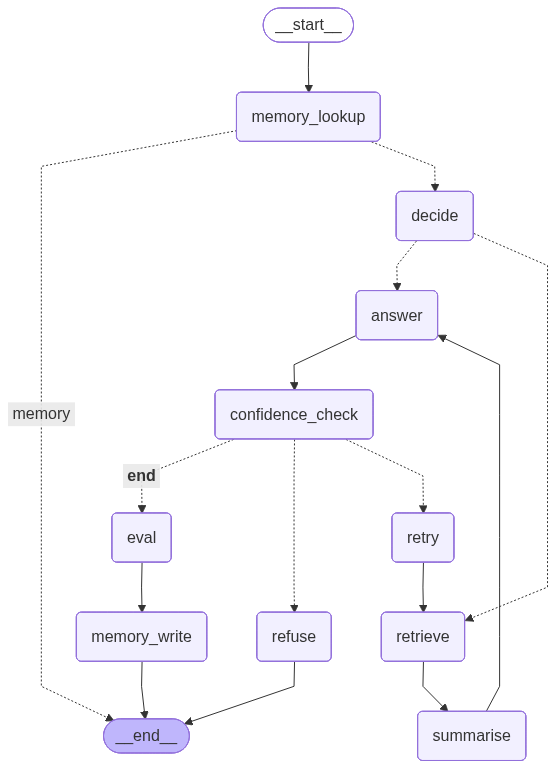

In [31]:
agent_app = graph.compile(debug=True)

png_bytes = agent_app.get_graph().draw_mermaid_png()

with open("agent_graph.png", "wb") as f:
    f.write(png_bytes)

# Display the image
from IPython.display import Image, display
display(Image("agent_graph.png"))


In [45]:
# Clear memory to test fresh queries
memory_store.clear()

result = agent_app.invoke({
    "query": "Tell me about embeddings",
    "distances": [],
    "context": None,
    "decision": "",
    "answer": None,
    "confidence": None,
    "retries": 0,
    "retrieval_stats": {},
    "memory_hit": False,
    "eval_score": None
})

# Print all details
print("=" * 60)
print("QUERY:", result["query"])
print("MEMORY HIT:", result.get("memory_hit", False))
print("DECISION:", result.get("decision", "N/A"))
print("-" * 60)
if result.get("distances"):
    print("DISTANCES:", [f"{d:.3f}" for d in result["distances"]])
    stats = result.get("retrieval_stats", {})
    if stats:
        print("RETRIEVAL STATS - Min:", f"{stats.get('min', 0):.3f}", "| Avg:", f"{stats.get('avg', 0):.3f}", "| Count:", stats.get('count', 0))
print("-" * 60)
print("CONTEXT SUMMARY:")
print(result.get("context", "No context"))
print("-" * 60)
print("ANSWER:", result["answer"])
print("-" * 60)
print("CONFIDENCE:", result.get("confidence", "N/A"))
print("EVAL SCORE:", result.get("eval_score", "N/A"))
print("RETRIES:", result.get("retries", 0))
print("=" * 60)


QUERY: Tell me about embeddings
MEMORY HIT: False
DECISION: retrieve
------------------------------------------------------------
DISTANCES: ['0.936', '1.129', '1.566']
RETRIEVAL STATS - Min: 0.936 | Avg: 1.210 | Count: 3
------------------------------------------------------------
CONTEXT SUMMARY:
Embeddings represent text semantics. In RAG, documents are converted to vectors within a vector space. FAISS provides efficient similarity search across these vectors.
------------------------------------------------------------
ANSWER: Embeddings represent text semantics as vectors in a vector space, enabling efficient similarity search with tools like FAISS.
------------------------------------------------------------
CONFIDENCE: 1.0
EVAL SCORE: 1.0
RETRIES: 0


Real tool usage (Wikipedia API)

In [76]:
# =========================
# FULL LANGGRAPH AGENT
# WITH REAL TOOL (OPEN-METEO)
# =========================

from typing import TypedDict, Optional, List
import requests
import faiss
import numpy as np

from sentence_transformers import SentenceTransformer
from langgraph.graph import StateGraph, END
from openai import OpenAI
import os

# -------------------------
# LLM CLIENT (OpenRouter)
# -------------------------
client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY")
)

def llm(prompt: str) -> str:
    resp = client.chat.completions.create(
        model="nvidia/nemotron-3-nano-30b-a3b:free",
        messages=[{"role": "user", "content": prompt}],
    )
    return resp.choices[0].message.content.strip()

# -------------------------
# AGENT STATE
# -------------------------
class AgentState(TypedDict):
    query: str
    context: Optional[str]
    answer: Optional[str]
    confidence: Optional[float]
    distances: List[float]

# -------------------------
# DOCUMENTS (RAG)
# -------------------------
documents = [
    "RAG stands for Retrieval-Augmented Generation.",
    "FAISS is a library for efficient similarity search.",
    "Embeddings capture semantic meaning of text.",
    "Large Language Models can hallucinate without grounding.",
    "Cristiano Ronaldo played for Real Madrid, Manchester United, Juventus, Sporting Lisbon, and Al Nassr."
]

def chunk(text, size=40):
    words = text.split()
    return [" ".join(words[i:i+size]) for i in range(0, len(words), size)]

chunks = []
for d in documents:
    chunks.extend(chunk(d))

# -------------------------
# EMBEDDINGS + FAISS
# -------------------------
embedder = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedder.encode(chunks).astype("float32")

index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

def retrieve_with_scores(query, k=3):
    q_emb = embedder.encode([query]).astype("float32")
    distances, indices = index.search(q_emb, k)
    results = []
    for d, i in zip(distances[0], indices[0]):
        results.append((chunks[i], float(d)))
    return results

# -------------------------
# REAL TOOL: WEATHER (NO API KEY)
# -------------------------
def weather_tool(city: str) -> str:
    geo = requests.get(
        "https://geocoding-api.open-meteo.com/v1/search",
        params={"name": city, "count": 1},
        timeout=5
    ).json()

    if "results" not in geo:
        return "Could not find city."

    lat = geo["results"][0]["latitude"]
    lon = geo["results"][0]["longitude"]

    weather = requests.get(
        "https://api.open-meteo.com/v1/forecast",
        params={
            "latitude": lat,
            "longitude": lon,
            "current_weather": True
        },
        timeout=5
    ).json()

    cw = weather.get("current_weather", {})
    return f"Temperature: {cw.get('temperature')}°C, Wind: {cw.get('windspeed')} km/h"

# -------------------------
# NODES
# -------------------------
def retrieve_node(state: AgentState):
    results = retrieve_with_scores(state["query"])
    state["context"] = "\n".join(r[0] for r in results)
    state["distances"] = [r[1] for r in results]
    return state

def confidence_check_node(state: AgentState):
    best = min(state["distances"])
    state["confidence"] = 1.0 if best < 1.2 else 0.2
    return state

def tool_router(state: AgentState):
    if "weather" in state["query"].lower():
        return "weather"
    return END

import re

def weather_node(state: AgentState):
    # Extract city name robustly
    match = re.search(r"weather in ([a-zA-Z\s]+)", state["query"].lower())
    
    if not match:
        state["context"] = "Could not extract city name."
        return state

    city = match.group(1).title().strip()
    state["context"] = weather_tool(city)
    return state


def answer_node(state: AgentState):
    prompt = f"""
Answer concisely.

Context:
{state["context"]}

Question:
{state["query"]}
"""
    state["answer"] = llm(prompt)
    return state

# -------------------------
# GRAPH
# -------------------------
graph = StateGraph(AgentState)

graph.add_node("retrieve", retrieve_node)
graph.add_node("confidence", confidence_check_node)
graph.add_node("weather", weather_node)
graph.add_node("answer", answer_node)

graph.set_entry_point("retrieve")

graph.add_edge("retrieve", "confidence")

graph.add_conditional_edges(
    "confidence",
    lambda s: "weather" if s["confidence"] < 0.5 else "answer",
    {
        "weather": "weather",
        "answer": "answer"
    }
)

graph.add_edge("weather", "answer")
graph.add_edge("answer", END)

agent = graph.compile(debug=True)

# -------------------------
# TESTS
# -------------------------
tests = [
    "What is FAISS?",
    "What clubs did Ronaldo play for?",
    "What is the weather in London?"
]

for q in tests:
    print("\nQUESTION:", q)
    result = agent.invoke({
        "query": q,
        "context": None,
        "answer": None,
        "confidence": None,
        "distances": []
    })
    print("ANSWER:", result["answer"])


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 939.67it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



QUESTION: What is FAISS?
[values] {'query': 'What is FAISS?', 'context': None, 'answer': None, 'confidence': None, 'distances': []}
[updates] {'retrieve': {'query': 'What is FAISS?', 'context': 'FAISS is a library for efficient similarity search.\nRAG stands for Retrieval-Augmented Generation.\nEmbeddings capture semantic meaning of text.', 'answer': None, 'confidence': None, 'distances': [1.2105169296264648, 1.8366180658340454, 1.875206470489502]}}
[values] {'query': 'What is FAISS?', 'context': 'FAISS is a library for efficient similarity search.\nRAG stands for Retrieval-Augmented Generation.\nEmbeddings capture semantic meaning of text.', 'answer': None, 'confidence': None, 'distances': [1.2105169296264648, 1.8366180658340454, 1.875206470489502]}
[updates] {'confidence': {'query': 'What is FAISS?', 'context': 'FAISS is a library for efficient similarity search.\nRAG stands for Retrieval-Augmented Generation.\nEmbeddings capture semantic meaning of text.', 'answer': None, 'confiden